# Export

In [1]:
import datetime
import os
from dataclasses import dataclass
from typing import Any, Dict, Tuple

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [4]:
path = "../logs/train/runs/2024-10-04_08-39-19/Common Buzzard/test_pred.nc"
data = xr.open_dataset(path)

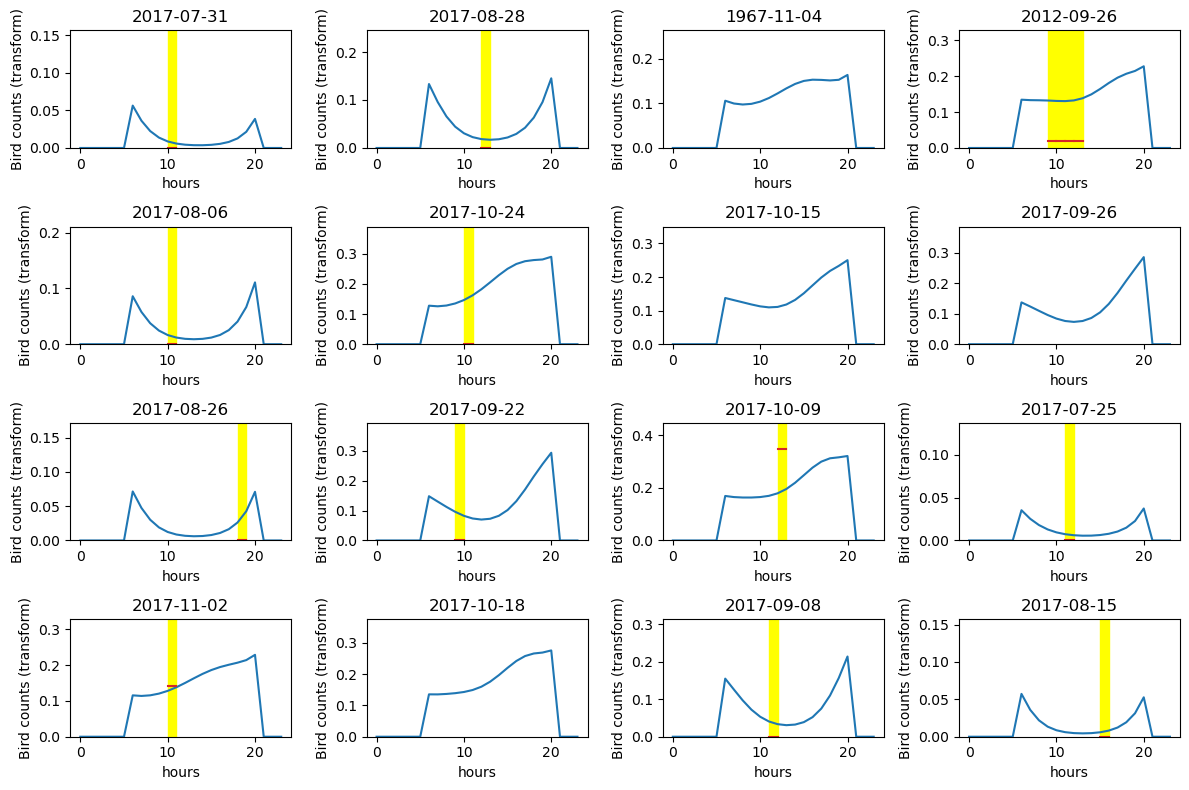

In [5]:
# def plt_timeseries(data):
fig, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
ax = ax.flatten()
for i, d in enumerate(np.random.randint(0, len(data.date), size=16)):
    subs = data.isel(date=d)

    ax[i].plot(np.arange(0, 24), subs.estimated_hourly_counts)
    for k, m in enumerate(subs.mask.values):
        if m == 1:
            ax[i].add_patch(Rectangle((k, 0), m, 10, color="yellow"))
            obs = subs.masked_total_counts.item() / subs.mask.sum().item()
            ax[i].plot([k, k + 1], [obs, obs], c="tab:red")

    ax[i].set_ylim(0, max(subs.estimated_hourly_counts.max(), obs) + 0.1)
    ax[i].set_xlabel("hours")
    ax[i].set_ylabel("Bird counts (transform)")
    ax[i].set_title(data.isel(date=d).date.dt.strftime("%Y-%m-%d").item())
# fig.savefig(f"{self.plotdir}/timeseries.jpg")
# plt.close()

In [ ]:
plt_timeseries

In [ ]:
daily_counts_log10 = data.sum(dim="time").estimated_hourly_counts
daily_counts = np.exp(daily_counts_log10) - 1

data_smooth = data.rolling({"time": 3}, center=True).mean()

fig, ax = plt.subplots(
    2, 3, figsize=(10, 5), tight_layout=True, sharex=True, sharey=True
)
ax = ax.flatten()
for k in range(len(data.date)):
    subset = data_smooth.isel(date=k)

    weights = subset.estimated_hourly_counts / subset.estimated_hourly_counts.sum()

    ax[k].bar(np.arange(24), weights * daily_counts[k])

    ax[k].set_title(subset.date.dt.strftime("%Y-%m-%d").item())
    ax[k].set_xticks(np.arange(0, 24, 3), [str(h) + "h" for h in np.arange(0, 24, 3)])

    ax[k].text(
        0.05,
        0.93,
        f"Total = {daily_counts[k]:.0f}",
        transform=ax[k].transAxes,
        fontsize=10,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="gray", alpha=0.25),
    )

ax[0].set_ylabel("Forecasted individual \ncounts (#)")
ax[3].set_ylabel("Forecasted individual \ncounts (#)")

plt.suptitle("Defile Bird Forecasts - Common Buzzard")
plt.show()

In [ ]:
data.sum(dim="time").estimated_hourly_counts.plot()
plt.show()

In [ ]:
path = r"C:\Users\amedee.roy\OneDrive - FRANCE ENERGIES MARINES\SCRIPTS\defile-migration-forecast\logs\train\runs\2024-07-16_11-03-35\test_pred.nc"
data = xr.open_dataset(path)
data = data.assign_coords(year=data["date"].dt.year)

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

fig, ax = plt.subplots(2, 3, figsize=(15, 6), tight_layout=True)
ax = ax.flatten()
for k, year in enumerate(np.unique(data.year)):

    sub = data.where(data.year == year, drop=True)
    sub = sub.groupby("date").mean()

    sub.masked_total_counts.plot(ax=ax[k], label="True")
    sub.estimated_masked_total_counts.plot(ax=ax[k], label="Prediction")

    score = r2_score(sub.masked_total_counts, sub.estimated_masked_total_counts)
    coeff = pearsonr(sub.masked_total_counts, sub.estimated_masked_total_counts)

    ax[k].annotate(
        rf"R$^2$ = {score:.2f}" + "\n" + rf"$\rho$ = {coeff.statistic:.2f}",
        xy=(0.05, 0.7),
        xycoords="axes fraction",
        bbox=dict(facecolor="grey", alpha=0.3),
    )

    ax[k].set_title(year)

plt.legend()
plt.show()

In [ ]:
subs

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
ax = ax.flatten()
for i, k in enumerate(np.random.randint(0, len(data.date), size=16)):
    subs = data.isel(date=k)
    ax[i].plot(np.arange(0, 24), subs.estimated_hourly_counts)
    ax[i].plot(np.arange(0, 24), subs.temperature_2m / 10)

In [ ]:
# path = r"C:\Users\amedee.roy\OneDrive - FRANCE ENERGIES MARINES\SCRIPTS\defile-migration-forecast\data\all_count_processed.csv"
# data = pd.read_csv(path, parse_dates=["date", "start", "end"])
# data['year'] = data['date'].dt.year
# data['obs_time'] = (data['end'] - data['start']).dt.seconds/3600
# data_demo = data.groupby(["year", "species"]).sum(numeric_only=True)
# data_demo['rel_count'] = data_demo['count'] / data_demo['obs_time']
# data_demo = data_demo.reset_index()

In [ ]:
# species = ["Milan noir", "Common Buzzard", "Bondrée apivore",
#             "Milan royal", "Épervier d'Europe", "Faucon crécerelle",
#             "Balbuzard pêcheur", "Faucon hobereau", "Busard Saint-Martin",
#             "Faucon émerillon", "Busard cendré", "Circaète Jean-le-Blanc"]

# fig, ax = plt.subplots(4,3, figsize=(12,8), tight_layout=True)
# ax = ax.flatten()
# for k, sp in enumerate(species):
#     sub = data_demo[data_demo.species == sp].copy()

#     x = np.linspace(min(sub.year), max(sub.year), 100)
#     coef = np.polyfit(sub.year, sub.rel_count, 5)
#     y = np.polyval(coef, x)

#     ax[k].plot(sub.year, sub.rel_count)
#     ax[k].plot(x, y)
#     ax[k].set_title(sp)

## Global metric


In [ ]:
true_count = data.masked_total_counts.values
pred_count = data.estimated_masked_total_counts.values

plt.hist(true_count, label="True count", alpha=0.5)
plt.hist(pred_count, label="Predicted count", alpha=0.5)
plt.xlabel("Count (log-scale)")
plt.ylabel("Histogram")
plt.legend()
plt.show()

In [ ]:
x = np.linspace(min(true_count), max(true_count), 100)
coef = np.polyfit(true_count, pred_count, 5)
y = np.polyval(coef, x)

plt.scatter(true_count, pred_count, c="black", s=5, alpha=0.4)
plt.plot(x, y, c="red")
plt.plot(x, x, "--", c="black")
plt.xlabel("True count (log-scale)")
plt.ylabel("Predicted count (log-scale)")
plt.show()

## Timeseries


In [ ]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(4, 4, figsize=(12, 8), tight_layout=True)
ax = ax.flatten()
for i, k in enumerate(np.random.randint(0, len(data.date), size=16)):
    subs = data.isel(date=k)

    ax[i].plot(np.arange(0, 24), subs.estimated_hourly_counts)
    for k, m in enumerate(subs.mask.values):
        if m == 1:
            ax[i].add_patch(Rectangle((k, 0), m, 10, color="yellow"))
            obs = subs.masked_total_counts.item() / subs.mask.sum().item()
            ax[i].plot([k, k + 1], [obs, obs], c="tab:red")

    ax[i].set_ylim(0, max(subs.estimated_hourly_counts.max(), obs) + 0.1)
    ax[i].set_xlabel("hours")
    ax[i].set_ylabel("Bird counts (log10)")
# plt.savefig(f'{self.plotdir}/plt_timeseries.jpg')

In [ ]:
data = data.assign_coords(doy=data.date.dt.dayofyear)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
data.groupby("doy").sum().masked_total_counts.plot(ax=ax, label="True")
data.groupby("doy").sum().estimated_masked_total_counts.plot(ax=ax, label="Prediction")
plt.legend()
plt.show()